In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torchvision.datasets import MNIST

In [2]:
basic_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

local_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.4, 0.4)),
    transforms.RandomGrayscale(p=0.3),
    transforms.GaussianBlur(kernel_size=9),
    transforms.RandomRotation(degrees=20),
    transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
])

global_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 0.8)),
    transforms.RandomGrayscale(p=0.1),
    transforms.GaussianBlur(kernel_size=9),
    transforms.RandomRotation(degrees=10),
    transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5,
                                                                     contrast=0.5,
                                                                     saturation=0.5,
                                                                     hue=0.1)
                                          ], p=0.8),
])

In [3]:
# Load the MNIST training/testing dataset
train_dataset = MNIST(root='./data', train=True, download=True, transform=basic_transform)
test_dataset = MNIST(root='./data', train=False, download=True, transform=basic_transform)


# Keep only 1500 samples in the training set
train_dataset.data = train_dataset.data[:1500]
train_dataset.targets = train_dataset.targets[:1500]

# Keep only 300 samples in the test set
test_dataset.data = test_dataset.data[:300]
test_dataset.targets = test_dataset.targets[:300]


# Create a dataloader for the training/testing dataset
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 125453635.74it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 124241737.26it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 34721119.15it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 14722201.52it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

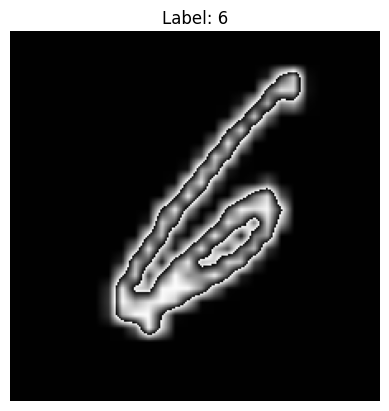

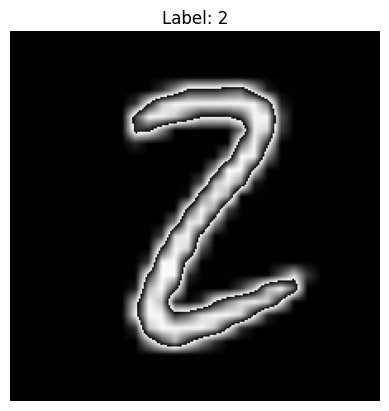

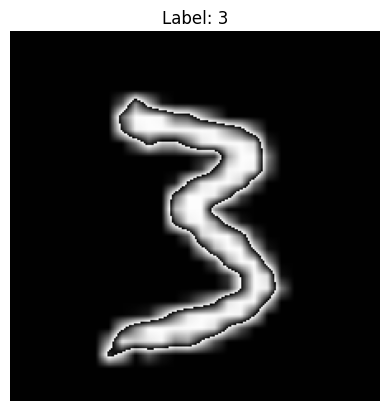

In [4]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

data_iter = iter(train_loader)

for batch_idx, (images, labels) in enumerate(data_iter):
    for i in range(3):  # Print three images
        image = images[i]
        label = labels[i]

        # Display the image
        image = TF.to_pil_image(image)
        plt.imshow(image)
        plt.title(f"Label: {label}")
        plt.axis('off')
        plt.show()

    if batch_idx == 0:  # Break out of the loop after three batches
        break

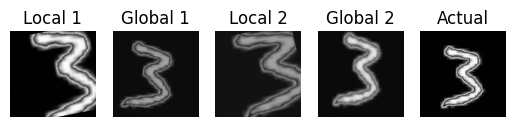

In [5]:
# Visualisation of the application of local and global transforms to the image
local_img_1 = local_transform(image)
global_img_1 = global_transform(image)

local_img_2 = local_transform(image)
global_img_2 = global_transform(image)

plt.subplot(1, 5, 1)
plt.imshow(local_img_1)
plt.title('Local 1')
plt.axis('off')

plt.subplot(1, 5, 2)
plt.imshow(global_img_1)
plt.title('Global 1')
plt.axis('off')


plt.subplot(1, 5, 3)
plt.imshow(local_img_2)
plt.title('Local 2')
plt.axis('off')

plt.subplot(1, 5, 4)
plt.imshow(global_img_2)
plt.title('Global 2')
plt.axis('off')


plt.subplot(1, 5, 5)
plt.imshow(image)
plt.title('Actual')
plt.axis('off')

plt.show()

In [6]:
# Define the Encoder (ResNet18 model without the last layer)
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        self.encoder = torchvision.models.resnet18(pretrained=False)
        self.encoder.fc = nn.Identity()  # Remove the last fully connected layer

    def forward(self, x):
        x = self.encoder(x)
        return x

# Define the Non-linear Projection Layer
class ProjectionLayer(nn.Module):
    def __init__(self, input_dim=512, output_dim=128):
        super(ProjectionLayer, self).__init__()
        self.projection_layer = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        x = self.projection_layer(x)
        return x

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.encoder = Encoder()
        self.projection_layer = ProjectionLayer()

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection_layer(x)
        return x


In [10]:
import torchsummary

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Model()

model.to(device)

input_shape = (3, 224, 224)

# Use torchsummary to print the model summary
torchsummary.summary(model, input_shape)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [11]:
input=torch.rand(1,3,224,224)
input=input.to(device)
output=model(input)
output

tensor([[ 1.6905e-01,  1.1164e-01,  3.0182e-01, -1.9688e-01, -2.1745e-01,
         -2.3369e-01, -5.1164e-02,  2.0337e-01, -2.7327e-01,  5.0425e-02,
         -2.6773e-01,  5.5604e-02, -3.3239e-01,  1.0325e-01,  1.6514e-02,
          1.0607e-01, -4.9778e-02, -9.9964e-05,  2.9617e-02, -8.3441e-02,
         -3.4990e-01, -2.3129e-01,  3.0127e-01,  2.5155e-01,  1.2848e-01,
          2.8117e-01,  4.4554e-01,  1.6347e-01,  1.0507e-01,  9.1532e-02,
         -2.8773e-01, -2.1147e-01, -6.6029e-02, -5.4826e-02, -2.6366e-01,
          8.4315e-02, -2.2112e-01, -2.2003e-01, -1.7826e-01, -2.4369e-01,
          1.2483e-01,  4.9248e-02, -7.5052e-02,  4.6428e-01,  1.6443e-02,
          1.0257e-01,  4.8991e-01, -9.7946e-02, -9.0440e-02,  1.7547e-01,
         -1.9049e-04,  8.0456e-02,  8.9801e-02, -1.4632e-01,  2.8518e-01,
         -2.4554e-01,  2.7197e-01,  1.8787e-01,  5.9163e-02,  2.4555e-01,
         -2.4042e-01, -3.7730e-01, -2.1592e-01,  1.8890e-01,  1.7114e-01,
         -1.7127e-01, -9.7195e-02, -1.

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

(1500, 128) (1500,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.121s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.015359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.538910


[t-SNE] KL divergence after 1000 iterations: 1.839782


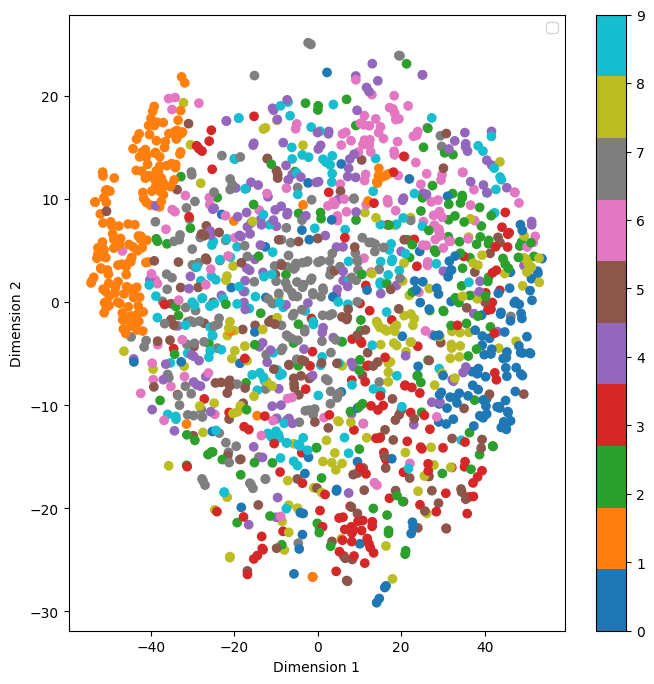

In [12]:
# Random Intialisation & projections in 1D
model.eval()
projections = []
labels=[]
import numpy as np

# Loop through the train data loader
for images, l in train_loader:
    # Move data to device
    
    images = images.to(device)
    #images = train_transform(images)

    l=l.to(device)

    # Compute embeddings
    with torch.no_grad():
        z = model(images)
        
    # Append embeddings to lists
    projections.append(z.cpu().numpy())
    labels.append(l.cpu().numpy())

# Concatenate embeddings from all batches
projections = np.concatenate(projections, axis=0)
labels = np.concatenate(labels, axis=0)

print(projections.shape, labels.shape)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import numpy as np

# Reduce dimensionality of features using t-SNE
tsne = TSNE(n_components=2, verbose=1)
features_tsne = tsne.fit_transform(projections)
color_map = ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(features_tsne[:,0], features_tsne[:,1], c=labels, cmap=color_map)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# Add a color bar to the plot to show the label-color mapping
cbar = plt.colorbar(scatter, ticks=np.unique(labels))
cbar.ax.set_yticklabels(np.unique(labels))

ax.legend()
plt.show()


In [15]:
def contrastive_loss(out_1, out_2, temperature):
    out = torch.cat([out_1, out_2], dim=0)
    n_samples = len(out)

    cov = torch.mm(out, out.t().contiguous())
    sim = torch.exp(cov / temperature)

    mask = ~torch.eye(n_samples, device=sim.device).bool()
    neg = sim.masked_select(mask).view(n_samples, -1).sum(dim=-1)

    pos = torch.exp(torch.sum(out_1 * out_2, dim=-1) / temperature)
    pos = torch.cat([pos, pos], dim=0)

    loss = -torch.log(pos / neg).mean()
    return loss

In [25]:
# define learning rate, weight decay and momentum
lr = 0.0001

wd= 0.00005

m=0.7

# define optimizer
optimizer= torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=m)

In [17]:
temperature = 0.67
num_epochs=25
# Training loop
for epoch in range(num_epochs):
    model.train()

    for batch_idx, (images, _) in enumerate(train_loader):
        # Transfer images and targets to the GPU if available
        images = images.to(device)
        
        # Contrastive Loss
        optimizer.zero_grad()
        
        # Generate local views
        local_view1 = local_transform(images)
        local_view2 = local_transform(images)
        
        # Compute embeddings and projections
        out_s1 = model(local_view1)
        out_s2 = model(local_view2)
        
        # Compute contrastive loss
        loss_contrastive = contrastive_loss(out_s1.cpu(), out_s2.cpu(), temperature)

        loss_contrastive.backward()

        optimizer.step()
        
    # Print training progress
    print('Epoch [{}/{}]: Loss Contrastive: {:.4f}'
          .format(epoch+1, num_epochs, loss_contrastive.item()))
    

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Epoch [1/25]: Loss Contrastive: 5.1737
Epoch [2/25]: Loss Contrastive: 5.0848
Epoch [3/25]: Loss Contrastive: 4.8512
Epoch [4/25]: Loss Contrastive: 4.7069
Epoch [5/25]: Loss Contrastive: 4.6593
Epoch [6/25]: Loss Contrastive: 4.5493
Epoch [7/25]: Loss Contrastive: 4.4416
Epoch [8/25]: Loss Contrastive: 4.4616
Epoch [9/25]: Loss Contrastive: 4.3187
Epoch [10/25]: Loss Contrastive: 4.5895
Epoch [11/25]: Loss Contrastive: 4.1768
Epoch [12/25]: Loss Contrastive: 4.1617
Epoch [13/25]: Loss Contrastive: 4.4003
Epoch [14/25]: Loss Contrastive: 4.1034
Epoch [15/25]: Loss Contrastive: 3.8511
Epoch [16/25]: Loss Contrastive: 4.0301
Epoch [17/25]: Loss Contrastive: 4.0061
Epoch [18/25]: Loss Contrastive: 3.5466
Epoch [19/25]: Loss Contrastive: 3.5900
Epoch [20/25]: Loss Contrastive: 4.2838
Epoch [21/25]: Loss Contrastive: 4.2655
Epoch [22/25]: Loss Contrastive: 3.8008
Epoch [23/25]: Loss Contrastive: 3.6903
Epoch [24/25]: Loss Contrastive: 4.5155
Epoch [25/25]: Loss Contrastive: 3.7350


(1500, 128) (1500,)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1500 samples in 0.001s...
[t-SNE] Computed neighbors for 1500 samples in 0.135s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1500
[t-SNE] Computed conditional probabilities for sample 1500 / 1500
[t-SNE] Mean sigma: 0.145336
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.083633


[t-SNE] KL divergence after 1000 iterations: 1.525614


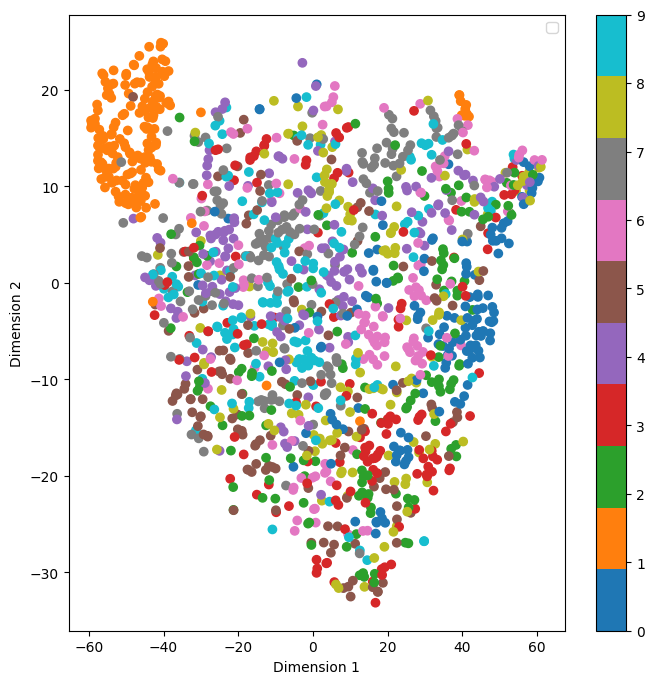

In [18]:
# Projections in 2D after Contrastive Learning, 25 epochs
model.eval()
projections = []
labels=[]
import numpy as np

# Loop through the train data loader
for images, l in train_loader:
    # Move data to device
    
    images = images.to(device)
    #images = train_transform(images)

    l=l.to(device)

    # Compute embeddings
    with torch.no_grad():
        z = model(images)
        
    # Append embeddings to lists
    projections.append(z.cpu().numpy())
    labels.append(l.cpu().numpy())

# Concatenate embeddings from all batches
projections = np.concatenate(projections, axis=0)
labels = np.concatenate(labels, axis=0)

print(projections.shape, labels.shape)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import numpy as np

# Reduce dimensionality of features using t-SNE
tsne = TSNE(n_components=2, verbose=1)
features_tsne = tsne.fit_transform(projections)
color_map = ListedColormap(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scatter = ax.scatter(features_tsne[:,0], features_tsne[:,1], c=labels, cmap=color_map)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')

# Add a color bar to the plot to show the label-color mapping
cbar = plt.colorbar(scatter, ticks=np.unique(labels))
cbar.ax.set_yticklabels(np.unique(labels))

ax.legend()
plt.show()


We can observe formation of clusters for instances with similar labels.

Training on larger datasets for large number of epochs with a particular choice of augmentations, tempearature & model architecture can give much better results.